In [17]:
# pytorch
import torch
import torch.nn as nn

# image transforms
from torchvision import transforms as T

# training and testing tools
from tqdm import tqdm
from multi_object_datasets_torch import MultiDSprites, ObjectsRoom
import matplotlib.pyplot as plt

# get GPU information
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used: {device}.")
if device == "cuda":
    print(f"Number of GPUs available: {torch.cuda.device_count()}.")
    torch.backends.cudnn.benchmark = True

Device being used: cpu.


<br>

# $\texttt{MiniMONet}$ ( ͡° ͜ʖ ͡°)

$\texttt{MONet}$ requires a substantial amount of computational resources, so we endeavoured to create a lighter model, which we named $\texttt{MiniMONet}$, that could produce similar results for lower-resolution images. $\texttt{MiniMONet}$ is implemented to work with $32 \times 32$-pixel images. The smaller input dimension results in the model having fewer learnable parameters. We experimented with removing certain layers from the network, as well as reducing the dimensionality of certain components, leading to a further decrease in the number of learnable parameters. The final $\texttt{MiniMONet}$ model consists of roughly $300,000$ learnable parameters, whereas $\texttt{MONet}$ consists of roughly $1,200,000$.

<br>

# Implementation details

The authors use a 6-block-high U-Net to implement the attention network of $\texttt{MONet}$ when working with $128 \times 128$-pixel images, and a 5-block-high U-Net when working with $64 \times 64$-pixel images. Following this pattern, $\texttt{MiniMONet}$ is implemented using a 4-block-high U-Net. This construction pattern results in the same dimensionality of the lowest/middlemost feature maps for all input sizes, but with a smaller number of feature maps. This leads to the inner MLP requiring fewer input and output nodes.

$\texttt{MiniMONet}$'s VAE uses one less layer for both the encoding and decoding processes, as well as fewer output channels from each convolutional layer. The same dimensionality of the latent representation is used in the final model (more on this below).

The kernels of the convolutional layers within both the attention network and the VAE are the same size as those of $\texttt{MONet}$. Padding, stride, existence of bias parameters, downsampling and upsampling factors and methods are the same as well.

### Attention Network

In [18]:
# attention network
class AttentionNetwork(nn.Module):

    def __init__(self, batchsize):
        super().__init__()
        self.batchsize = batchsize

        # input is RGB image + scope
        # input: (batch size, number of channels, image height, image width)
        # (B, C, H, W) = (64, 4, 32, 32)

        # down block 1
        self.downblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 8, affine = True),
            nn.ReLU()) # (B, C, H, W) = (64, 8, 32, 32)
        self.downsample1 = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)
        # (B, C, H, W) = (64, 8, 16, 16)

        # down block 2
        self.downblock2 = nn.Sequential(
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 16, affine = True),
            nn.ReLU()) # (B, C, H, W) = (64, 16, 16, 16)
        self.downsample2 = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)
        # (B, C, H, W) = (64, 16, 8, 8)

        # down block 3
        self.downblock3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 32, affine = True),
            nn.ReLU()) # (B, C, H, W) = (64, 32, 8, 8)
        self.downsample3 = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)
        # (B, C, H, W) = (64, 32, 4, 4)

        # down block 4
        self.downblock4 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 64, affine = True),
            nn.ReLU()) # (B, C, H, W) = (64, 64, 4, 4)
        
        # 3-layer MLP
        self.MLP = nn.Sequential(
            nn.Flatten(), # flatten to (64, 64 x 4 x 4 = 1024, 1, 1)
            nn.Linear(in_features = 1024, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = 1024),
            nn.ReLU()) # reshape to (64, 64, 4, 4)
        
        # up blocks
        self.upblock1 = nn.Sequential(
            # concatenate with (64, 64, 4, 4) to get (64, 128, 4, 4)
            nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 32, affine = True),
            nn.ReLU(), # (B, C, H, W) = (64, 32, 4, 4)
            nn.Upsample(scale_factor = 2, mode = "nearest")) # (B, C, H, W) = (64, 32, 8, 8)
        self.upblock2 = nn.Sequential(
            # concatenate with (64, 32, 8, 8) to get (64, 64, 8, 8)
            nn.Conv2d(in_channels = 64, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 16, affine = True),
            nn.ReLU(), # (B, C, H, W) = (64, 16, 8, 8)
            nn.Upsample(scale_factor = 2, mode = "nearest")) # (B, C, H, W) = (64, 16, 16, 16)
        self.upblock3 = nn.Sequential(
            # concatenate with (64, 16, 16, 16) to get (64, 32, 16, 16)
            nn.Conv2d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 8, affine = True),
            nn.ReLU(), # (B, C, H, W) = (64, 8, 16, 16)
            nn.Upsample(scale_factor = 2, mode = "nearest")) # (B, C, H, W) = (64, 8, 32, 32)
        self.upblock4 = nn.Sequential(
            # concatenate with (64, 8, 32, 32) to get (64, 16, 32, 32)
            nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.InstanceNorm2d(num_features = 4, affine = True),
            nn.ReLU()) # (B, C, H, W) = (64, 4, 32, 32)

        # final output layer produces the attention mask at recurrent step k
        self.finalattention = nn.Conv2d(in_channels = 4, out_channels = 1, kernel_size = 1, stride = 1, padding = 0, bias = True)
        # (B, C, H, W) = (64, 1, 32, 32)

    def forward(self, x, log_scope_k):

        # RGB image + scope
        x0 = torch.concat((x, log_scope_k), dim = 1)

        # down the U-net
        x1 = self.downblock1(x0) # first skip tensor
        x2 = self.downblock2(self.downsample1(x1)) # second skip tensor
        x3 = self.downblock3(self.downsample2(x2)) # third skip tensor
        x4 = self.downblock4(self.downsample3(x3)) # fourth skip tensor

        # through the 3-layer MLP
        y = self.MLP(x4).reshape(self.batchsize, 64, 4, 4)

        # up the U-net
        y = self.upblock1(torch.concat((y, x4), dim = 1)) # concat first skip tensor
        y = self.upblock2(torch.concat((y, x3), dim = 1)) # concat second skip tensor
        y = self.upblock3(torch.concat((y, x2), dim = 1)) # concat third skip tensor
        y = self.upblock4(torch.concat((y, x1), dim = 1)) # concat fourth skip tensor

        # final layer
        alpha_k = self.finalattention(y)

        # compute scope and mask
        log_alpha_k = nn.LogSigmoid()(alpha_k)
        log_scope_kplus1 = log_scope_k + log_alpha_k - alpha_k
        log_mask_k = log_scope_k + log_alpha_k

        # output scope and mask
        return log_scope_kplus1, log_mask_k

### Component VAE

In [19]:
# component variational autoencoder
class ComponentVAE(nn.Module):

    def __init__(self, batchsize):
        super().__init__()
        self.batchsize = batchsize

        # input is RGB image + attention mask at recurrent step k
        # input: (batch size, number of channels, image height, image width)
        # (B, C, H, W) = (64, 4, 32, 32)

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 4, out_channels = 16, kernel_size = 3, stride = 2, padding = 1, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 16, 16, 16)
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 32, 8, 8)
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 32, 4, 4)
            nn.Flatten(), # flatten to (64, 32 x 4 x 4 = 512, 1, 1)
            nn.Linear(in_features = 512, out_features = 128),
            nn.Linear(in_features = 128, out_features = 32)) # 16-dimensional latent representation

        # sample latent distribution: (B, C, H, W) = (64, 16, 1, 1)
        # spatial broadcast/tiling: (B, C, H, W) = (64, 16, 38, 38)
        # concat coordinate channels: (B, C, H, W) = (64, 18, 38, 38)

        # decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels = 18, out_channels = 32, kernel_size = 3, stride = 1, padding = 0, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 32, 36, 36)
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 0, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 32, 34, 34)
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1, padding = 0, bias = True),
            nn.ReLU(), # (B, C, H, W) = (64, 16, 32, 32)
            nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = 1, stride = 1, padding = 0, bias = True))
            # final output layer produces reconstructed component and mask
            # (B, C, H, W) = (64, 4, 32, 32)

    def forward(self, x, log_mask_k):

        # RGB image + attention mask at recurrent step k
        x0 = torch.concat((x, log_mask_k), dim = 1)

        # encode
        latent = self.encoder(x0)

        # extract latent parameters mu and log sigma
        mu = torch.split(latent, 16, dim = 1)[0]
        log_sigma = torch.split(latent, 16, dim = 1)[1]

        # sample from the distribution
        z = mu + torch.exp(log_sigma) * torch.randn_like(log_sigma)

        # broadcast the latent vector across space
        z = z.reshape((self.batchsize, 16, 1, 1)).repeat((1, 1, 38, 38))

        # coordinate channels for each spacial dimension
        dim1 = torch.linspace(-1, 1, 38, device = device)
        dim2 = torch.linspace(-1, 1, 38, device = device)
        dim1, dim2 = torch.meshgrid(dim1, dim2, indexing = "ij")
        dim1 = dim1.reshape((1, 1, 38, 38)).repeat((self.batchsize, 1, 1, 1))
        dim2 = dim2.reshape((1, 1, 38, 38)).repeat((self.batchsize, 1, 1, 1))

        # z + coordinate channels
        z = torch.concat((z, dim1, dim2), dim = 1)

        # decode
        reconstructed = self.decoder(z)

        # extract reconstructed image and mask
        x_hat_mu = torch.split(reconstructed, [3, 1], dim = 1)[0]
        mask_hat_logits = torch.split(reconstructed, [3, 1], dim = 1)[1]

        # output latent parameters and reconstructed component and mask
        return mu, log_sigma, x_hat_mu, mask_hat_logits

### $\texttt{MiniMONet}$

In [20]:
# mini monet
class MiniMONet(nn.Module):

    def __init__(self, slots, batchsize, learningrate):
        super().__init__()

        # total number of recurrent steps and total number of attention masks
        self.K = slots

        # initialize networks
        self.batchsize = batchsize
        self.attn = AttentionNetwork(self.batchsize)
        self.vae = ComponentVAE(self.batchsize)

        # tuning parameters for the terms of the loss function
        self.alpha = 1
        self.beta = 0.5
        self.gamma = 0.5

        # output component distribution is an independent pixel-wise Gaussian with ﬁxed scales
        self.sigma_bg = 0.09 # background
        self.sigma_fg = 0.11 # foreground

        # optimize learning using RMSProp
        self.learningrate = learningrate
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = self.learningrate)

    def forward(self, x):

        # attention network output
        log_scope = torch.zeros((self.K, self.batchsize, 1, 32, 32), device = device)
        log_scope[0] = torch.log(torch.ones((self.batchsize, 1, 32, 32), device = device))
        log_mask = torch.zeros((self.K, self.batchsize, 1, 32, 32), device = device)

        # VAE latent distribution parameters
        mu = torch.zeros((self.K, self.batchsize, 16), device = device)
        log_sigma = torch.zeros((self.K, self.batchsize, 16), device = device)
        
        # VAE output
        x_hat_mu = torch.zeros((self.K, self.batchsize, 3, 32, 32), device = device)
        mask_hat_logits = torch.zeros((self.K, self.batchsize, 1, 32, 32), device = device)

        # run K - 1 recurrent steps and send attention masks to VAE
        for k in range(self.K - 1):
            log_scope[k + 1], log_mask[k] = self.attn(x, log_scope[k])
            mu[k], log_sigma[k], x_hat_mu[k], mask_hat_logits[k] = self.vae(x, log_mask[k])
        
        # run Kth recurrent step and send attention mask to VAE
        log_mask[self.K - 1] = log_scope[self.K - 1]
        mu[self.K - 1], log_sigma[self.K - 1], x_hat_mu[self.K - 1], mask_hat_logits[self.K - 1] = self.vae(x, log_mask[self.K - 1])

        # output attention mask and latent parameters and reconstructed component and mask
        return log_mask, mu, log_sigma, x_hat_mu, mask_hat_logits

    def learn(self, dataloaders, epochs):

        # optimize training
        scaler = torch.amp.GradScaler("cuda")

        # here we go
        losses = []
        for epoch in tqdm(range(epochs)):

            # iterate over each dataset
            losses.append([])
            for dataloader in dataloaders:

                # iterate over each batch
                for i, x in enumerate(dataloader):

                    # normalize pixel values
                    image = (x["image"] / 255).to(device)

                    # skip batches that are not full
                    if image.shape[0] != self.batchsize: break

                    # compute loss
                    self.optimizer.zero_grad(set_to_none = True)
                    with torch.autocast(device):

                        # forward pass for a batch
                        # mus, log_sigs, log_masks, recon_comp_means, recon_mask_logits = self(image)
                        log_mask, mu, log_sigma, x_hat_mu, mask_hat_logits = self(image)

                        # output component distribution is an independent pixel-wise Gaussian with ﬁxed scales
                        x_hat_sigma = torch.Tensor([self.sigma_bg if k == 0 else self.sigma_fg for k in range(self.K)])

                        # first loss - VAE decoder negative log likelihood
                        # weighted with hyperparameter alpha = 1
                        loss1 = 0
                        for j in range(0, self.K):
                            temp = torch.exp(log_mask[j] - torch.log(x_hat_sigma[j]) - 0.5 * (image - x_hat_mu[j]).pow(2) / x_hat_sigma[j].pow(2))
                            loss1 = loss1 + temp
                        loss1 = torch.sum(-torch.log(loss1))
                        loss1 = self.alpha * loss1 / self.batchsize

                        # second loss - VAE KL divergence of latent posterior factored across slots and latent prior
                        # weighted with hyperparameter beta which encourages learning of disentangled latent representations
                        loss2 = 0
                        for j in range(0, self.K):
                            temp = torch.sum(torch.exp(log_sigma[j]).pow(2) + mu[j].pow(2) - 2 * log_sigma[j] - 1) / 2 # from lecture notes pg. 113/114
                            loss2 = loss2 + temp
                        loss2 = self.beta * loss2 / self.batchsize

                        # third loss - KL divergence of attention mask distribution and VAE decoded mask distribution
                        # weighted with hyperparameter gamma which modulates how closely the VAE must model the attention mask distribution
                        loss3 = nn.KLDivLoss(reduction = "sum", log_target = True)(nn.LogSoftmax(dim = 0)(mask_hat_logits), log_mask)
                        loss3 = self.gamma * loss3 / self.batchsize

                        # total loss
                        loss = loss1 + loss2 + loss3

                    # backward pass and parameter update
                    scaler.scale(loss).backward()
                    scaler.unscale_(self.optimizer)
                    scaler.step(self.optimizer)
                    scaler.update()

                    # training history
                    losses[epoch].append((loss.detach().item(), loss1.detach().item(), loss2.detach().item(), loss3.detach().item()))

        # done studying
        return

<br>

# Training details

In order to train $\texttt{MiniMONet}$, we scaled down the $\texttt{MultiDSprites}$ and $\texttt{ObjectsRoom}$ datasets using nearest-neighbour interpolation, since this method of interpolation produced the cleanest separation of the objects within the images. Other methods of interpolation resulted in significant blurring of the images, due to the smaller resolution. In order to make a fair comparison of the performance of the mini model, we require images with clear borders between objects and background components.

In [21]:
datasets = []
datasets.append(MultiDSprites("datasets", version = "colored_on_colored", split = "Train",
	transforms = {"image": T.Resize(32, T.InterpolationMode.NEAREST)},
	download = False, convert = False))
datasets.append(MultiDSprites("datasets", version = "colored_on_grayscale", split = "Train",
	transforms = {"image": T.Resize(32, T.InterpolationMode.NEAREST)},
	download = False, convert = False))
datasets.append(ObjectsRoom("datasets", split = "Train",
	transforms = {"image": T.Resize(32, T.InterpolationMode.NEAREST)},
	download = False, convert = False))

<br>

# Experimental results

During the construction of $\texttt{MiniMONet}$, we attempted to reduce the latent dimensionality of the VAE from 16 dimensions to 8. The model struggled to accurately disentangle as well as reconstruct the elements of a scene, especially objects occupying fewer pixels. This suggests that the dimensionality of the latent representation is integral to the success of the model. The final mini model uses 16 dimensions.

$\texttt{MiniMONet}$ performs similarly to $\texttt{MONet}$ when scenes are composed of less elements, but struggles to disentangle every unique element when there are more. These results are also indicated by the larger error measurements displayed in Table 1 of the Appendix. This performance suggests that the overall architecture of the multi-object network may not be scalable, unless computational resources are accessible.

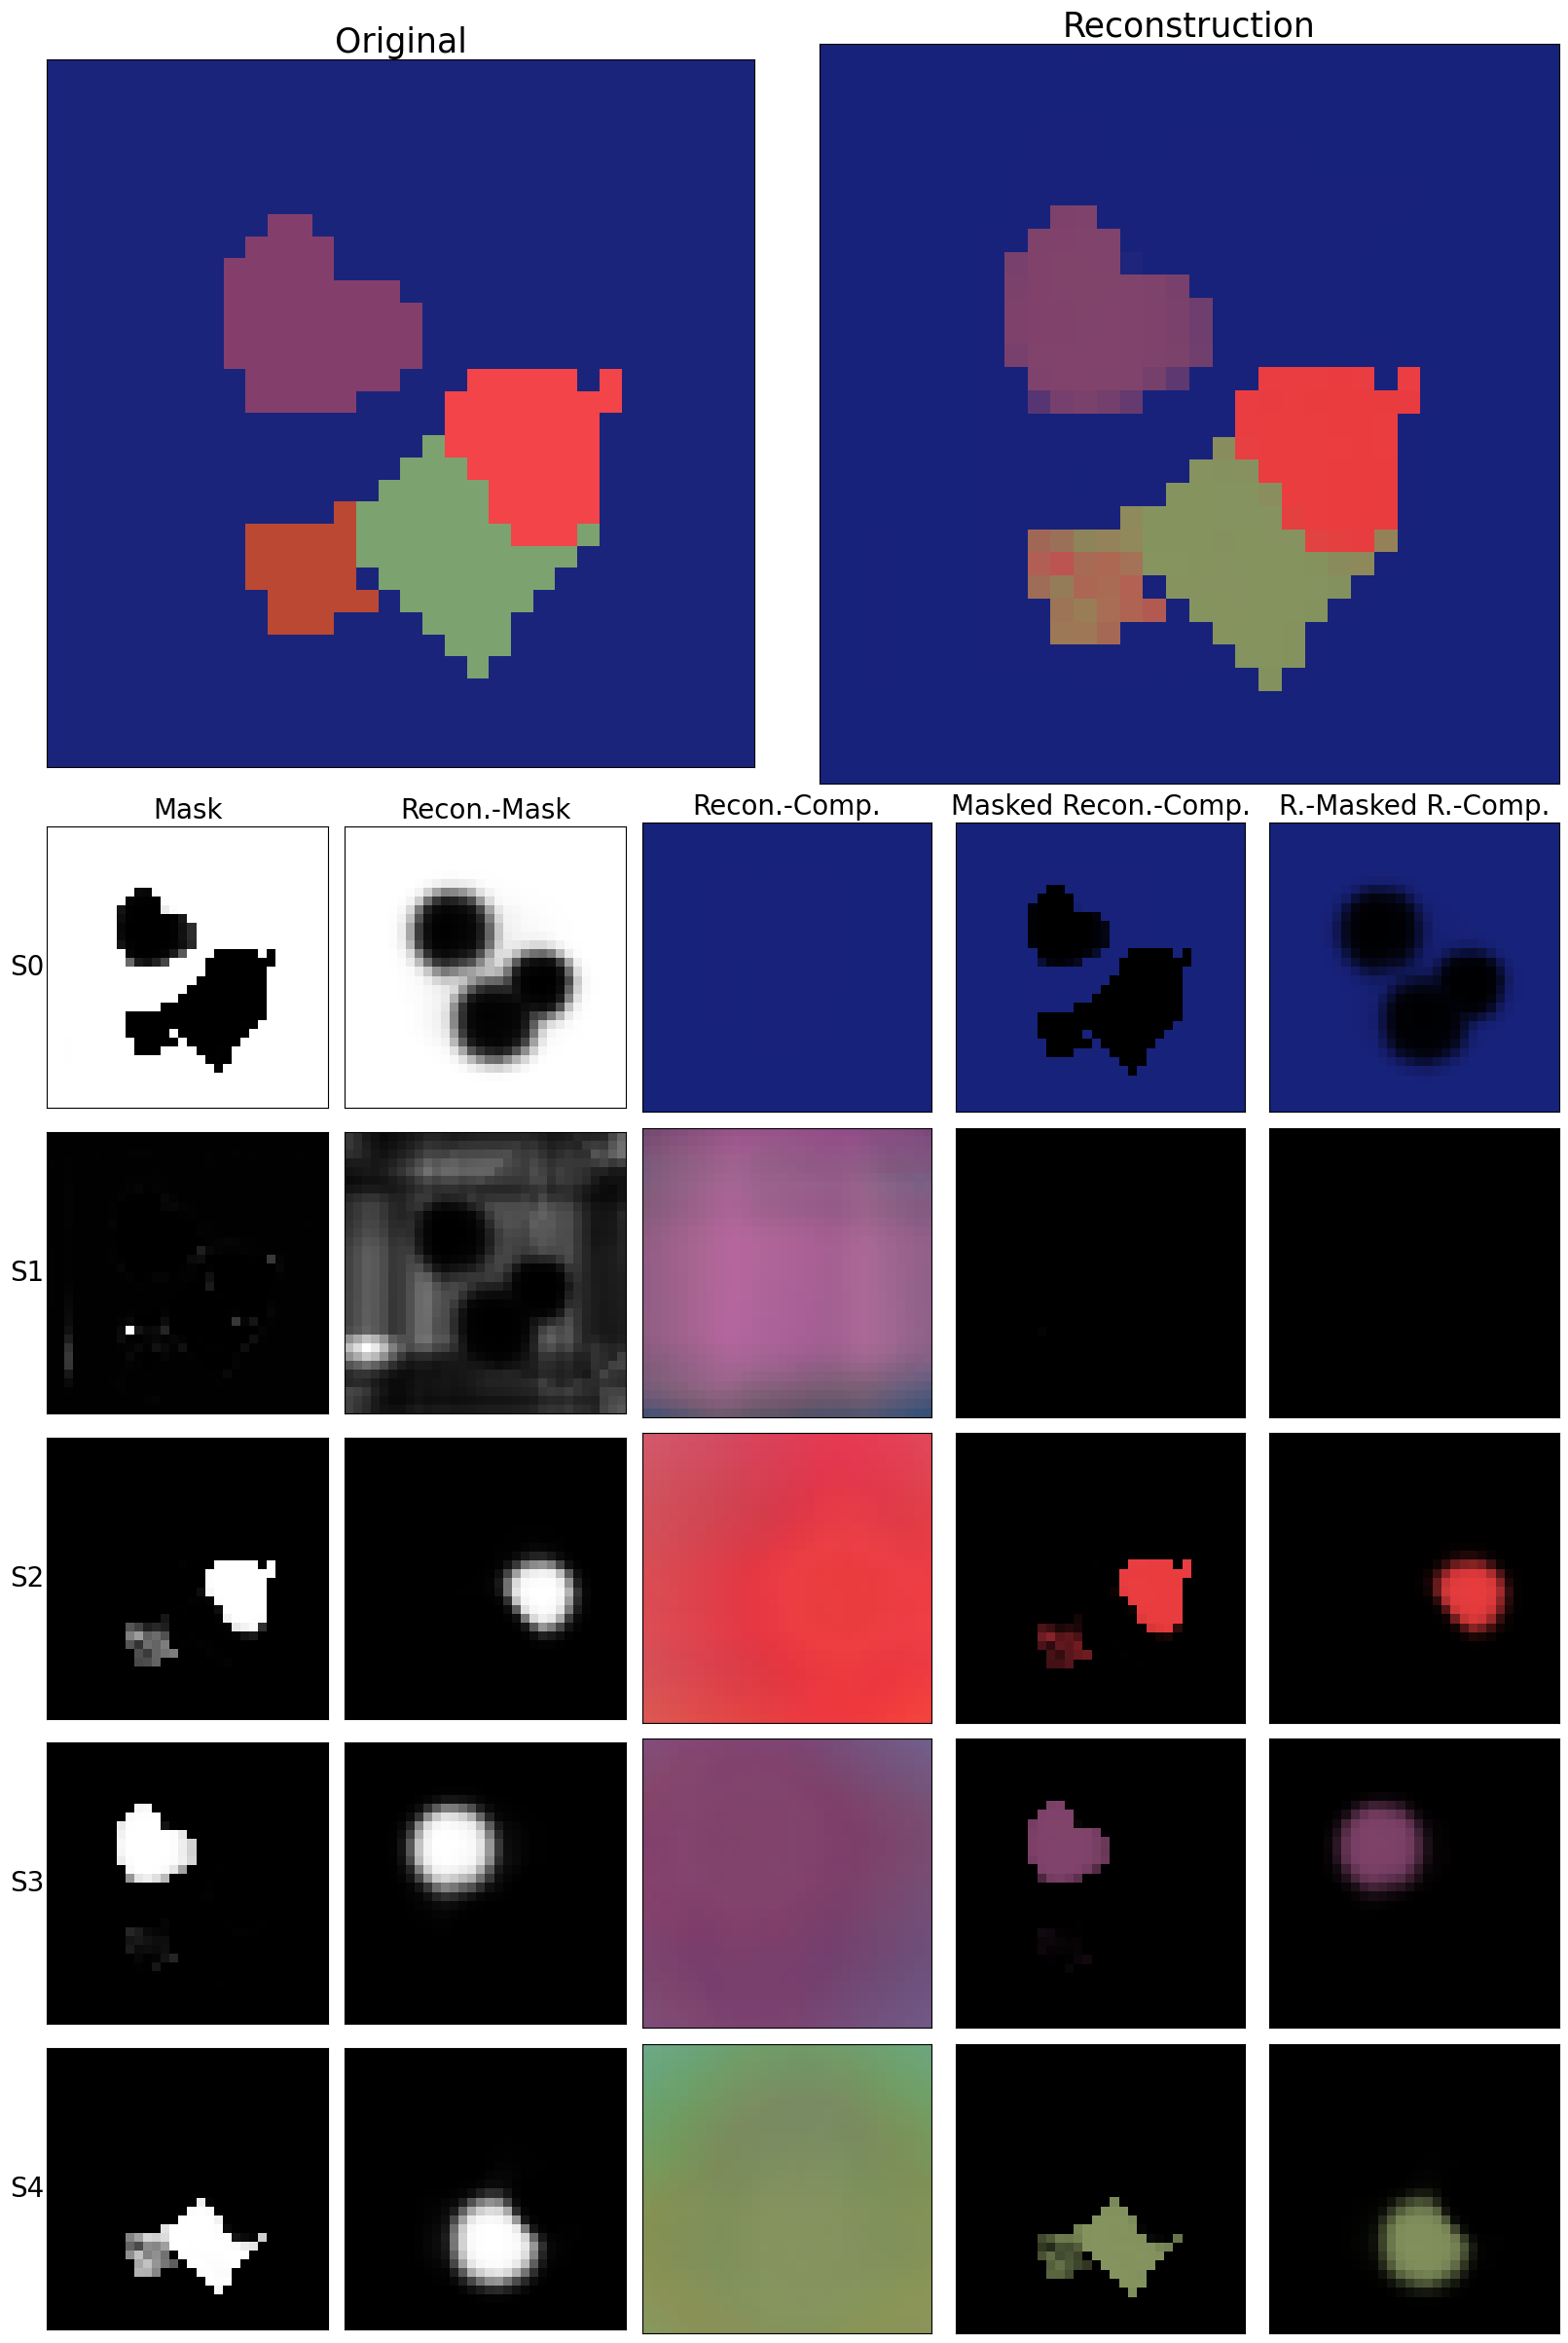

In [22]:
# plotting function
def drawsummaryfigure(model, image):

	# run batch through model
	with torch.no_grad():
		log_mask, _, _, x_hat_mu, mask_hat_logits = model((image / 255).to(device))
		mask = torch.exp(log_mask)
		reconstructedcomponent = x_hat_mu
		reconstructedmask = nn.Softmax(dim = 0)(mask_hat_logits)

	# plot summary figures
	mosaic = [["original", "original", "original", "original", "original",
		"reconstruction", "reconstruction", "reconstruction", "reconstruction", "reconstruction"]]
	for k in range(mini.K):
		mosaic.append([f"mask_{k}", f"mask_{k}",
			f"recon_mask_{k}", f"recon_mask_{k}",
			f"recon_comp_{k}", f"recon_comp_{k}",
			f"recon_comp_mask_{k}", f"recon_comp_mask_{k}",
			f"recon_comp_recon_mask_{k}", f"recon_comp_recon_mask_{k}"])
	_, axes = plt.subplot_mosaic(mosaic,
		height_ratios = [2.5] + [1] * model.K,
		gridspec_kw = {"wspace": 0, "hspace": 0}, constrained_layout = True,
		figsize = (5 * 3 + 1, model.K * 3 + 1 + 8))

	# display original image prominently
	axes["original"].imshow(image[0].permute(1, 2, 0))
	axes["original"].set_title("Original", fontsize=25)
	# display model's reconstructed image prominently (main result)
	axes["reconstruction"].imshow(torch.clamp(torch.sum(torch.mul(mask[:,0], reconstructedcomponent[:,0]), dim=0).permute(1, 2, 0), min=0, max=1))
	axes["reconstruction"].set_title("Reconstruction", fontsize=25)

	# display labels for each column of the slot summary
	axes["mask_0"].set_title("Mask", fontsize=20)
	axes["recon_mask_0"].set_title("Recon.-Mask", fontsize=20)
	axes["recon_comp_0"].set_title("Recon.-Comp.", fontsize=20)
	axes["recon_comp_mask_0"].set_title("Masked Recon.-Comp.", fontsize=20)
	axes["recon_comp_recon_mask_0"].set_title("R.-Masked R.-Comp.", fontsize=20)

	# generate required summary plots for each slot
	for k in range(model.K):
		# display label for each slot
		axes[f"mask_{k}"].set_ylabel(f"S{k}", rotation=0, va="center", labelpad=15, fontsize=20)
		# display image for each important feature of plot
		axes[f"mask_{k}"].imshow(torch.clamp(mask[k][0].permute(1, 2, 0), min=0, max=1), cmap="gray")
		axes[f"recon_mask_{k}"].imshow(torch.clamp(reconstructedmask[k][0].permute(1, 2, 0), min=0, max=1), cmap="gray")
		axes[f"recon_comp_{k}"].imshow(torch.clamp(reconstructedcomponent[k][0].permute(1, 2, 0), min=0, max=1))
		axes[f"recon_comp_mask_{k}"].imshow(torch.clamp(torch.mul(mask[k][0], reconstructedcomponent[k][0]).permute(1, 2, 0), min=0, max=1))
		axes[f"recon_comp_recon_mask_{k}"].imshow(torch.clamp(torch.mul(reconstructedmask[k][0], reconstructedcomponent[k][0]).permute(1, 2, 0), min=0, max=1))

	# figures have no axis ticks or labels and square images
	for key in axes.keys():
		axes[key].set_xticks([])
		axes[key].set_xticklabels([])
		axes[key].set_yticks([])
		axes[key].set_yticklabels([])
		axes[key].set_aspect("equal")

# choose a trained model:
# 0 = model trained on MultiDSprites, 1 = model trained on ObjectsRoom
model = 0
mini = MiniMONet(slots = 5, batchsize = 1, learningrate = 0.0001)
if (model == 0): mini.load_state_dict(torch.load(f"models/MONet_Mini_MultiDSprites.pt",
	weights_only = False, map_location = torch.device(device)))
elif (model == 1): mini.load_state_dict(torch.load(f"models/MONet_Mini_ObjectsRoom.pt",
	weights_only = False, map_location = torch.device(device)))

# choose an image from a dataset:
# dataset: 0 = MultiDSprites coloured, 1 = MultiDSprites grayscale, 2 = ObjectsRoom
# datapoint: 0 ... 89999
dataset, datapoint = 0, 2025
image = datasets[dataset][datapoint]["image"]

# run the image through the trained model
drawsummaryfigure(mini, image.unsqueeze(0))